# Datasets

Датасет 1 - успеваемость студентов [ссылка](https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset)

В нем есть посещаемость, успеваемость и время которое люди тратят на обучение

Датасет 2 - члены спортзала [ссылка](https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset)

В нем есть данные о людях и их тренировках

В обоих датасетах нет пропусков данных.

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import classification_report
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

In [2]:
dataset1 = pd.read_csv("student_performance.csv")
dataset2 = pd.read_csv("gym_members.csv")

In [3]:
# Turn gender into int
dataset2['Gender'] = dataset2['Gender'].replace({'Female': '0', 'Male': '1'}).infer_objects(copy=False)

In [4]:
# One Hot Workout Type 
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)
dataset2 = encode_and_bind(dataset2, "Workout_Type")

In [5]:
dataset1.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [6]:
dataset2.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
0,56,1,88.3,1.71,180,157,60,1.69,1313.0,12.6,3.5,4,3,30.20,False,False,False,True
1,46,0,74.9,1.53,179,151,66,1.30,883.0,33.9,2.1,4,2,32.00,False,True,False,False
2,32,0,68.1,1.66,167,122,54,1.11,677.0,33.4,2.3,4,2,24.71,True,False,False,False
3,25,1,53.2,1.70,190,164,56,0.59,532.0,28.8,2.1,3,1,18.41,False,False,True,False
4,38,1,46.1,1.79,188,158,68,0.64,556.0,29.2,2.8,3,1,14.39,False,False,True,False


In [7]:
# Classification dataset from dataset1
# Target is GradeClass
class_1 = dataset1.drop(columns=["Ethnicity", "StudentID", "GPA"])
X_class_1 = class_1.drop(["GradeClass"], axis=1)
y_class_1 = class_1["GradeClass"]

Xc1_train, Xc1_test, yc1_train, yc1_test = train_test_split(X_class_1, y_class_1, test_size=0.3)

In [8]:
# Classification dataset from dataset2
# Target is Gender
class_2 = dataset2.drop(columns=[])
X_class_2 = class_2.drop(["Gender"], axis=1)
y_class_2 = class_2["Gender"]

Xc2_train, Xc2_test, yc2_train, yc2_test = train_test_split(X_class_2, y_class_2, test_size=0.3)

In [9]:
# Regression dataset from dataset1
# Target is GPA (Grade Point Average)
regr_1 = dataset1.drop(columns=["Ethnicity", "StudentID", "GradeClass"])
X_regr_1 = regr_1.drop(["GPA"], axis=1)
y_regr_1 = regr_1["GPA"]

Xr1_train, Xr1_test, yr1_train, yr1_test = train_test_split(X_regr_1, y_regr_1, test_size=0.3)

In [10]:
# Regression dataset from dataset2
# Target is Calories_Burned
regr_2 = dataset2.drop(columns=[])
X_regr_2 = regr_2.drop(["Calories_Burned"], axis=1)
y_regr_2 = regr_2["Calories_Burned"]

Xr2_train, Xr2_test, yr2_train, yr2_test = train_test_split(X_regr_2, y_regr_2, test_size=0.3)

# Classification

## Dataset 1 (Student Performance)

### Decision Tree (Overfit)

In [11]:
# Decision tree (regression or classification) in sklearn is
# overfit by default and all its leaves are pure
dtc1_overfit = DecisionTreeClassifier()
dtc1_overfit.fit(Xc1_train, yc1_train);

In [12]:
print("Tree Accuracy", dtc1_overfit.score(Xc1_test, yc1_test))

Tree Accuracy 0.6239554317548747


### Decision Tree (Not Overfit)

In [13]:
dtc1 = DecisionTreeClassifier(
    min_samples_split=20,
    min_samples_leaf=7,
)
dtc1.fit(Xc1_train, yc1_train);

In [14]:
print("Tree Accuracy", dtc1.score(Xc1_test, yc1_test))

Tree Accuracy 0.6601671309192201


### Default Random Forest

```
n_estimators=100,
criterion='gini',
max_depth=None,
min_samples_split=2,
min_samples_leaf=1,
max_features='sqrt',
max_leaf_nodes=None,
```

In [15]:
rfc1_default = RandomForestClassifier()
rfc1_default.fit(Xc1_train, yc1_train);

In [16]:
print("Forest Accuracy", rfc1_default.score(Xc1_test, yc1_test))

Forest Accuracy 0.7047353760445683


In [17]:
rfc1_default_pred = rfc1_default.predict(Xc1_test)
print(classification_report(yc1_test, rfc1_default_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.16      0.26        31
         1.0       0.45      0.42      0.43        78
         2.0       0.52      0.54      0.53       119
         3.0       0.48      0.55      0.51       108
         4.0       0.89      0.90      0.89       382

    accuracy                           0.70       718
   macro avg       0.59      0.51      0.52       718
weighted avg       0.70      0.70      0.70       718



In [18]:
# Importances should be labeled pandas series
def plot_mdi_importance(importance, title="Feature importances using MDI"):
    importance = importance.sort_values(ascending=False)
    fig, ax = plt.subplots()
    importance.plot.barh(ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Mean decrease in impurity")
    fig.tight_layout()

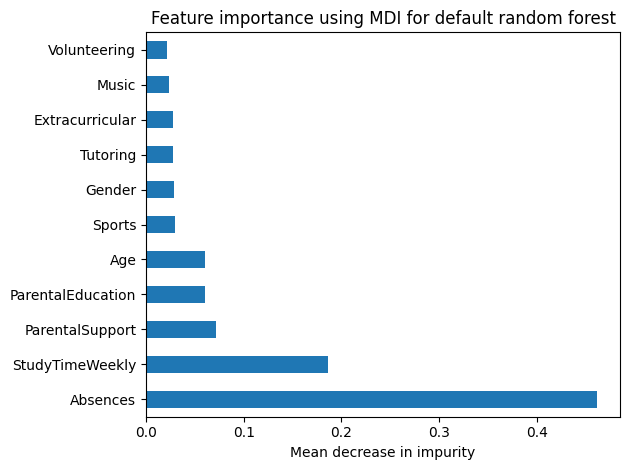

In [19]:
# Feature importance using mean decrease in impurity
rfc1_default_importances = pd.Series(rfc1_default.feature_importances_, index=Xc1_test.columns)
plot_mdi_importance(rfc1_default_importances, "Feature importance using MDI for default random forest")

### OOB Score Random Forest

In [20]:
# We have to enable out-of-bag score
# By default accuracy_score is used
rfc1_oob = RandomForestClassifier(
    oob_score=True,
)
rfc1_oob.fit(Xc1_train, yc1_train);

In [21]:
print("Forest OOB Score", rfc1_oob.oob_score_)

Forest OOB Score 0.7132616487455197


In [22]:
print("Forest Accuracy", rfc1_oob.score(Xc1_test, yc1_test))

Forest Accuracy 0.7089136490250696


In [23]:
rfc1_oob_pred = rfc1_oob.predict(Xc1_test)
print(classification_report(yc1_test, rfc1_oob_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.16      0.26        31
         1.0       0.46      0.38      0.42        78
         2.0       0.49      0.57      0.53       119
         3.0       0.49      0.54      0.51       108
         4.0       0.90      0.91      0.90       382

    accuracy                           0.71       718
   macro avg       0.59      0.51      0.52       718
weighted avg       0.71      0.71      0.70       718



### Parameter tuning

#### Max Features

In [24]:
def plot_score_features_subspace(feats, scores):
    fig, ax = plt.subplots()
    ax.plot(feats, scores)
    ax.set_xlabel("Features")
    ax.set_ylabel("Accuracy")
    fig.tight_layout()

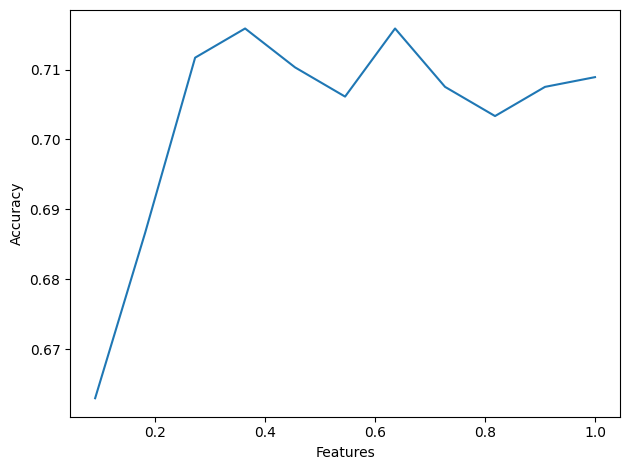

In [25]:
feats = []
scores = []
n = len(Xc1_train.columns)
for i in range(1, n+1):
    max_features = i/n
    rf = RandomForestClassifier(
        max_features=max_features,
    )
    rf.fit(Xc1_train, yc1_train)
    score = rf.score(Xc1_test, yc1_test)
    feats.append(max_features)
    scores.append(score)
plot_score_features_subspace(feats, scores)

#### Number of Trees

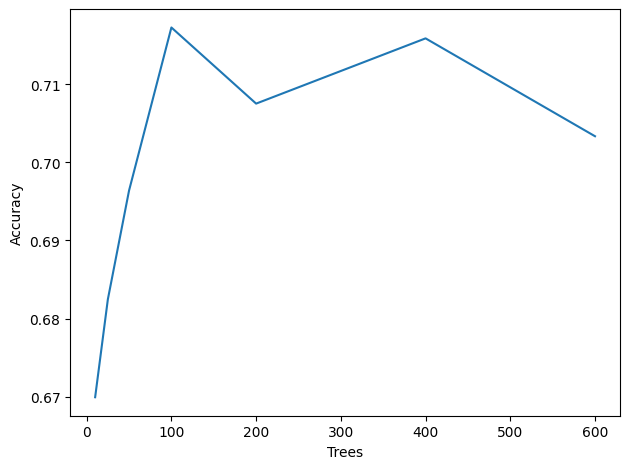

In [26]:
estimators = [10, 25, 50, 100, 200, 400, 600]
scores = []
n = len(Xc1_train.columns)
for n_estimators in estimators:
    rf = RandomForestClassifier(
        n_estimators=n_estimators
    )
    rf.fit(Xc1_train, yc1_train)
    score = rf.score(Xc1_test, yc1_test)
    feats.append(max_features)
    scores.append(score)
fig, ax = plt.subplots()
ax.plot(estimators, scores)
ax.set_xlabel("Trees")
ax.set_ylabel("Accuracy")
fig.tight_layout()

## Dataset 2 (Gym Members)

### Decision Tree (Overfit)

In [27]:
dtc2_overfit = DecisionTreeClassifier()
dtc2_overfit.fit(Xc2_train, yc2_train);

In [28]:
print("Tree Accuracy", dtc2_overfit.score(Xc2_test, yc2_test))

Tree Accuracy 0.9383561643835616


### Decision Tree (Not Overfit)

In [29]:
dtc2 = DecisionTreeClassifier(
    min_samples_split=20,
    min_samples_leaf=7,
)
dtc2.fit(Xc2_train, yc2_train);

In [30]:
print("Tree Accuracy", dtc2.score(Xc2_test, yc2_test))

Tree Accuracy 0.9486301369863014


### Default Random Forest

In [31]:
rfc2_default = RandomForestClassifier()
rfc2_default.fit(Xc2_train, yc2_train);

In [32]:
print("Forest Accuracy", rfc2_default.score(Xc2_test, yc2_test))

Forest Accuracy 0.9691780821917808


In [33]:
rfc2_default_pred = rfc2_default.predict(Xc2_test)
print(classification_report(yc2_test, rfc2_default_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       130
           1       1.00      0.94      0.97       162

    accuracy                           0.97       292
   macro avg       0.97      0.97      0.97       292
weighted avg       0.97      0.97      0.97       292



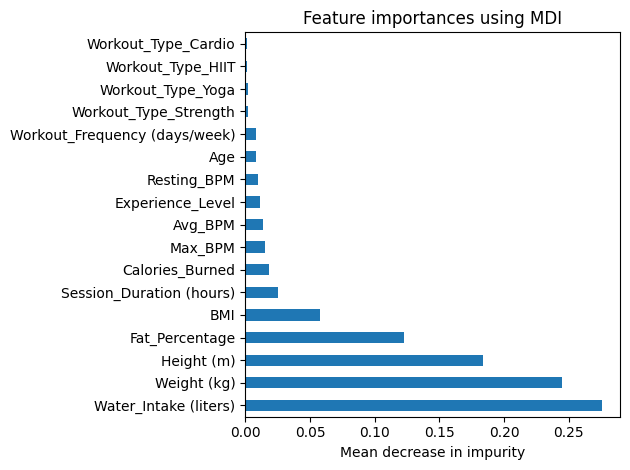

In [34]:
# Feature importance using mean decrease in impurity
rfc2_default_importances = pd.Series(rfc2_default.feature_importances_, index=Xc2_test.columns)
plot_mdi_importance(rfc2_default_importances)

### Parameter tuning

#### Max Features

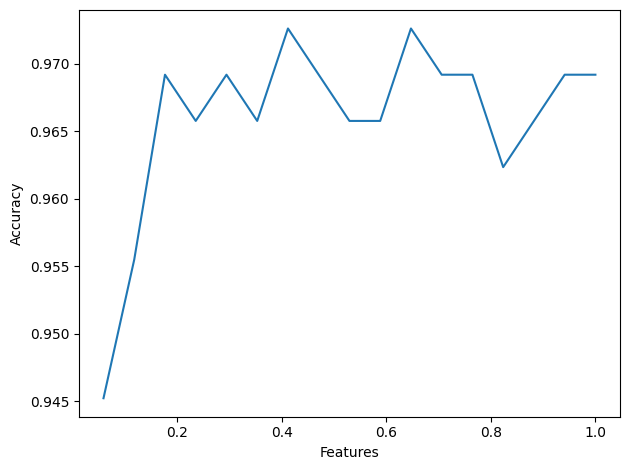

In [35]:
feats = []
scores = []
n = len(Xc2_train.columns)
for i in range(1, n+1):
    max_features = i/n
    rf = RandomForestClassifier(
        max_features=max_features,
    )
    rf.fit(Xc2_train, yc2_train)
    score = rf.score(Xc2_test, yc2_test)
    feats.append(max_features)
    scores.append(score)
plot_score_features_subspace(feats, scores)

#### Number of Trees

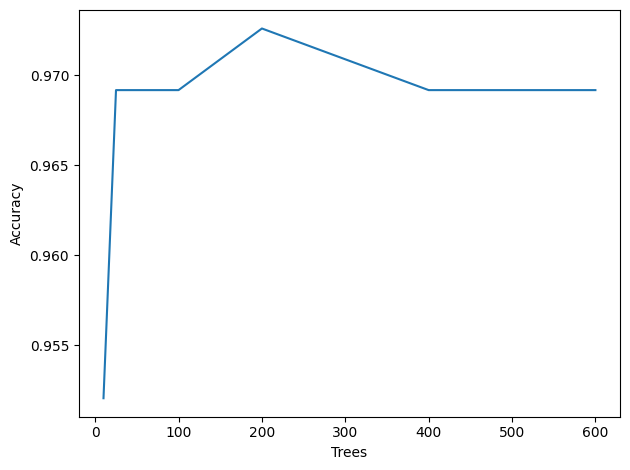

In [36]:
estimators = [10, 25, 50, 100, 200, 400, 600]
scores = []
n = len(Xc2_train.columns)
for n_estimators in estimators:
    rf = RandomForestClassifier(
        n_estimators=n_estimators
    )
    rf.fit(Xc2_train, yc2_train)
    score = rf.score(Xc2_test, yc2_test)
    feats.append(max_features)
    scores.append(score)
fig, ax = plt.subplots()
ax.plot(estimators, scores)
ax.set_xlabel("Trees")
ax.set_ylabel("Accuracy")
fig.tight_layout()

# Regression

## Dataset 1 (Student Performance)

### Decision Tree (Overfit)

In [37]:
# Decision tree (regression or classification) in sklearn is
# overfit by default and all its leaves are pure
dtr1_overfit = DecisionTreeRegressor()
dtr1_overfit.fit(Xr1_train, yr1_train);

In [38]:
dtr1_overfit_pred = dtr1_overfit.predict(Xr1_test)
print("Tree Score (R2)", dtr1_overfit.score(Xr1_test, yr1_test))
print("Tree MAE", mean_absolute_error(yr1_test, dtr1_overfit_pred))
print("Tree MSE", mean_squared_error(yr1_test, dtr1_overfit_pred))

Tree Score (R2) 0.8615154469756503
Tree MAE 0.2789550759791934
Tree MSE 0.1233740181956848


### Decision Tree (Not Overfit)

In [39]:
dtr1= DecisionTreeRegressor(
    min_samples_split=20,
    min_samples_leaf=7,
)
dtr1.fit(Xr1_train, yr1_train);

In [40]:
dtr1_pred = dtr1.predict(Xr1_test)
print("Tree Score (R2)", dtr1.score(Xr1_test, yr1_test))
print("Tree MAE", mean_absolute_error(yr1_test, dtr1_pred))
print("Tree MSE", mean_squared_error(yr1_test, dtr1_pred))

Tree Score (R2) 0.8909653693064142
Tree MAE 0.2531020954402471
Tree MSE 0.09713748008259783


### Default Random Forest

```
n_estimators=100,
criterion='squared_error',
max_depth=None,
min_samples_split=2,
min_samples_leaf=1,
max_features=1.0,
max_leaf_nodes=None,
```

In [41]:
rfr1_default = RandomForestRegressor()
rfr1_default.fit(Xr1_train, yr1_train);

In [42]:
rfr1_default_pred = rfr1_default.predict(Xr1_test)
print("Forest Score (R2)", rfr1_default.score(Xr1_test, yr1_test))
print("Forest MAE", mean_absolute_error(yr1_test, rfr1_default_pred))
print("Forest MSE", mean_squared_error(yr1_test, rfr1_default_pred))

Forest Score (R2) 0.9311127591585918
Forest MAE 0.19929740294890097
Forest MSE 0.06137071261315378


## Dataset 2 (Gym Members)

### Decision Tree (Overfit)

In [43]:
dtr2_overfit = DecisionTreeRegressor()
dtr2_overfit.fit(Xr2_train, yr2_train);

In [44]:
dtr2_overfit_pred = dtr2_overfit.predict(Xr2_test)
print("Tree Score (R2)", dtr2_overfit.score(Xr2_test, yr2_test))
print("Tree MAE", mean_absolute_error(yr2_test, dtr2_overfit_pred))
print("Tree MSE", mean_squared_error(yr2_test, dtr2_overfit_pred))

Tree Score (R2) 0.9298871650607445
Tree MAE 53.70205479452055
Tree MSE 5177.640410958904


### Decision Tree (Not Overfit)

In [45]:
dtr2= DecisionTreeRegressor(
    min_samples_split=20,
    min_samples_leaf=7,
)
dtr2.fit(Xr2_train, yr2_train);

In [46]:
dtr2_pred = dtr2.predict(Xr2_test)
print("Tree Score (R2)", dtr2.score(Xr2_test, yr2_test))
print("Tree MAE", mean_absolute_error(yr2_test, dtr2_pred))
print("Tree MSE", mean_squared_error(yr2_test, dtr2_pred))

Tree Score (R2) 0.9248745137059935
Tree MAE 58.12637342687506
Tree MSE 5547.810954524757


### Default Random Forest

In [47]:
rfr2_default = RandomForestRegressor()
rfr2_default.fit(Xr2_train, yr2_train);

In [48]:
rfr2_default_pred = rfr2_default.predict(Xr2_test)
print("Forest Score (R2)", rfr2_default.score(Xr2_test, yr2_test))
print("Forest R2", r2_score(yr2_test, rfr2_default_pred))
print("Forest MAE", mean_absolute_error(yr2_test, rfr2_default_pred))
print("Forest MSE", mean_squared_error(yr2_test, rfr2_default_pred))

Forest Score (R2) 0.9742080873378252
Forest R2 0.9742080873378252
Forest MAE 33.47729452054795
Forest MSE 1904.6619551369863


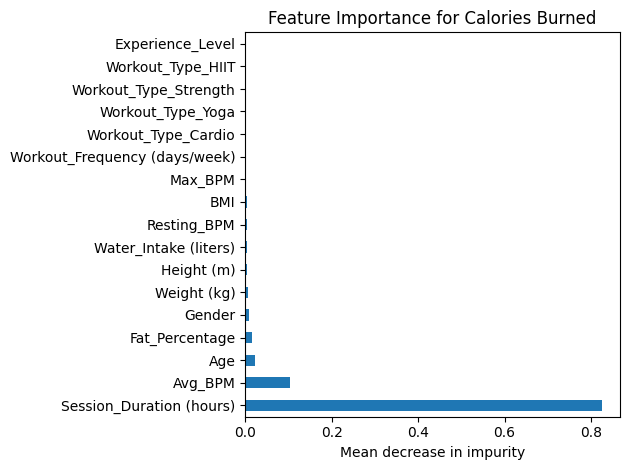

In [49]:
# Feature importance using mean decrease in impurity
rfr2_default_importances = pd.Series(rfr2_default.feature_importances_, index=Xr2_test.columns)
plot_mdi_importance(rfr2_default_importances, title="Feature Importance for Calories Burned")